Start!

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
# import time

In [3]:
import astropy.units as u
import numpy as np
import pandas as pd
import astropy.constants as c

In [4]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from rounded_single_pad import Round_TransmonPocket_Single as transmon
import Transmon_property as trans_p
import Transmon_specifications as jj
from dolan_junction import DolanJunction as junction
import Default_params as dp


In [5]:
# from qiskit_metal import designs, draw
# from qiskit_metal import MetalGUI, Dict, Headings

# from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

# from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
# from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

In [6]:
# import seaborn as sns

In [7]:
# phi0 = c.h/2/c.e.si
# T = 30*u.mK
# epsilon_r = 11.45
# cc = 1664080*u.fF/u.m

In [8]:
from qiskit_metal import MetalGUI, Dict
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
gui = MetalGUI(dp.design)

07:59PM 08s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 141 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 



2023-04-13 19:59:08.656 python[76749:8595038] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Component-specific variables

In [9]:
design = dp.design

junction_layer = 5
qubit_layer = 2

## Single Pad--Verify Design

### Draw the single pad transmon

In [10]:
design.delete_all_components()

In [11]:
design.overwrite_enabled = True

size = 0.25*u.mm
gap = 30*u.um
size = size.to(u.um)
pocket_width = size+2*gap


op = Dict(
    pos_x = '0',
    pad_height = '{}um'.format(size.value),
    pos_y = '0',
    pad_width = '{}'.format(size),
    pocket_width = '{}'.format(pocket_width), 
    **dp.qb_options)

q1 = transmon(design,'Q1',options = op)

gui.rebuild()
gui.zoom_on_components(['Q1'])


In [12]:
q1.options['junction'] = 'True'

In [13]:
gui.rebuild()

In [14]:
design.chips.main.size['size_x'] = '20 mm'
design.chips.main.size['size_y'] = '10 mm'
gds = design.renderers.gds

In [15]:
guesses = pd.read_csv(r'data/educated_guess_0403.csv')

In [16]:
options = Dict(taper_len='0.5um',jj_gap = '0.14um')
d = junction(design, 'd', options = options)


In [17]:
k = 3

q1.options['pad_height'] = '{}um'.format(guesses['Sizes (um)'].values[k])
q1.options['pad_width'] = '{}um'.format(guesses['Sizes (um)'].values[k])

q1.options['pocket_width'] = '{}um'.format(guesses['Sizes (um)'].values[k]+2*gap.to(u.um).value)

q1.options['connection_pads']['a']['pad_width'] = guesses['Coupling_len'][k]
q1.options['connection_pads']['a']['pad_height'] = '30um-{}um'.format(guesses['Coupling_gap(um)'][k])
q1.options['connection_pads']['a']['pad_gap'] = '{}um'.format(guesses['Coupling_gap(um)'][k])

d.options['Lj'] = '{}'.format(guesses['Ljs (nH)'][k])

q1.options.layer = qubit_layer
d.options.layer = junction_layer

gui.rebuild()
gui.zoom_on_components(['Q1'])
    

In [18]:
q1, d = jj.place_junction(q1,d)
gui.rebuild()


In [19]:
dp.TQ_options['down_length'] = '40 um'
TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='-0.1 mm',
                                             pos_y='0.5 mm',
                                             mirror = True,
                                             coupling_length='120 um', **dp.TQ_options))
TQ1.options['open_termination'] = False

gui.rebuild()
gui.autoscale()

In [20]:
q1,j, cpw, TQ1, design,gui = dp.construct_cpw_qubit(q1,d, TQ1, 5,gui,design,sim =False)
q1, d = jj.place_junction(q1,d)
gui.rebuild()
gui.autoscale()

07:59PM 25s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


214.0 um
214.0 um
-(214.0 um/2+40um-80 um/4)+0


07:59PM 25s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


Construct the cpw airbridge object

In [24]:
import numpy as np
import astropy.units as u
from qiskit_metal import draw, Dict
from qiskit_metal.qlibrary.core import QComponent


def equals(a,b):
    return abs(a-b)<1e-6
def find_line_direction(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    if x1 == x2:
        if y1>y2:
            return 270
        elif y1<y2:
            return 90
        else:
            return 0
    elif equals(y1, y2):
        if x1>x2:
            return 180
        elif x1<x2:
            return 0
        else: return 0
    else:
        return ((np.arctan((y2-y1)/(x2-x1))*180/np.pi)+360)%360
def find_segment_length(p1,p2, type):
    x1,y1 = p1
    x2,y2 = p2
    d1 = np.absolute(x2-x1)
    d2 = np.absolute(y2-y1)
    if type == 'straight':
        return np.sqrt(d1**2+d2**2)
    elif equals(d1, d2) and (type == 'arc'):
        # print('arc!')
        return d1*np.pi/2
    else:
        r = max(d1, d2)
        r_min = min(d1, d2)
        theta = np.arctan(r_min/r)
        return d1*theta/2
def find_coordinates(coordinates, r):
    segment_start = []
    segment_end = []
    segment_type = []
    segment_angle = []
    segment_length = []
    seg_all = []

    for i, cords in enumerate(coordinates):
        
        if i ==0:
            seg_all.append(coordinates[i])
            segment_start.append(coordinates[i])
            continue
        elif i == len(coordinates)-1:
            # seg_all.append(coordinates[i-1])
            seg_all.append(coordinates[i])
            segment_start.append(segment_end[-1])
            segment_end.append(coordinates[i])
            segment_type.append('straight')
            angle = find_line_direction(coordinates[i-1],coordinates[i])
            length = find_segment_length(coordinates[i-1],coordinates[i], type = 'straight')
            segment_length.append(length)
            segment_angle.append(angle)
            break
        angle = find_line_direction(coordinates[i-1],cords)
        next_angle = find_line_direction(cords,coordinates[i+1])
        # print(angle, next_angle)
        # print(np.absolute(angle-next_angle))
        if angle == next_angle:
            continue
        elif np.absolute(angle-next_angle)%90==0:
            x, y = cords
            x0,y0 = coordinates[i-1]
            x_modi = x - np.sign(x - x0)*r
            y_modi = y - np.sign(y - y0)*r
            if i == 1:
                pass
            else:
                segment_start.append(segment_end[-1])
            segment_end.append((x_modi,y_modi))
            segment_type.append('straight')
            segment_angle.append(angle)
            length = find_segment_length(segment_start[-1],segment_end[-1], type = 'straight')
            segment_length.append(length)


            x1,y1 = coordinates[i+1]
            x1_modi = x + np.sign(x1 - x)*r
            y1_modi = y + np.sign(y1 - y)*r
            segment_start.append((x_modi,y_modi))
            segment_end.append((x1_modi,y1_modi))
            segment_type.append('arc')
            angle = (angle+next_angle)/2
            segment_angle.append(angle)
            length = find_segment_length(segment_start[-1],segment_end[-1], type = 'arc')
            segment_length.append(length)

            # seg_all.append(coordinates[i-1])
            seg_all.append((x_modi,y_modi))
            seg_all.append((x1_modi,y1_modi))
            segment = {}
            segment['start'] = segment_start
            segment['end'] = segment_end
            segment['angle'] = segment_angle
            segment['length'] = segment_length
            segment['type'] = segment_type

    return segment    
def make_ab_element(cpw,arc_bridge = False):
    
    r = design.parse_value(cpw.options.fillet)
    center_pin = design.parse_value(cpw.options.trace_width)
    gap_w = design.parse_value(cpw.options.trace_gap)

    xover_len = center_pin + 2*gap_w
    box_side = 0
    xover_width = 0
    if 0.05<=xover_len<=0.016:
        box_side = 0.008
        xover_width = 0.005
    elif 0.016<xover_len<=0.027:
        box_side = 0.01
        xover_width = 0.0075
    elif 0.027<xover_len<=0.032:
        box_side = 0.014
        xover_width = 0.01
    else:
        print('error!!!')
    out_box_len = box_side + 0.002*2
    r_in = r-center_pin/2-gap_w
    if r_in < out_box_len:
        print('error!!!')
    else:
        ab_inside_extend = r_in - np.sqrt(r_in**2 - out_box_len**2)

        
    square_in = draw.rectangle(box_side, box_side)
    square_out = draw.rectangle(out_box_len, out_box_len)
    squares = [square_in, square_out]
    sq_in_left, sq_out_left = draw.translate(squares,-xover_len/2-out_box_len/2,0)
    sq_in_right, sq_out_right = draw.translate(squares,xover_len/2+out_box_len/2,0)
    
    if arc_bridge == True:
        xover_rec = draw.rectangle(xover_len+ ab_inside_extend, xover_width )
        sq_in_right, sq_out_right = draw.translate([sq_in_right, sq_out_right],
                                                ab_inside_extend/2,0)
        base = draw.shapely.unary_union((sq_out_left, xover_rec, sq_out_right))
    else:
        xover_rec = draw.rectangle(xover_len, xover_width)
        base = draw.shapely.unary_union((sq_out_left, xover_rec, sq_out_right))

    top = draw.shapely.unary_union((sq_in_left, sq_in_right))
    return top, base
    # angle_in_data = 315
    # rotation_angle = -(90-angle_in_data)
    # base = draw.rotate(base, rotation_angle)
    # top = draw.rotate(top, rotation_angle)

    # pos = (0,0)
    # x, y = pos
    # base = draw.translate(base, x, y)
    # top = draw.translate(top, x, y)

def find_next_ab(segment_all, distance, ab_all, cpw_turn_radi, clockwise = 1):
    last_pt = ab_all['coord'][-1]
    last_len = ab_all['length_remain'][-1]
    seg_num = ab_all['seg_num'][-1]
    smaller = True
    last_angle = segment_all['angle'][seg_num]
    if last_len >= distance:
        ab_all['length_remain'].append(last_len-distance)
        ab_all['seg_num'].append(seg_num)
        x,y = last_pt
        if segment_all['type'][seg_num] == 'straight':
            angle = last_angle/180*np.pi
            x_new = x + distance*np.cos(angle)
            y_new = y + distance*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            angle = angle*180/np.pi
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(False)
            
            return ab_all, True
        else:
            len_needed = distance
            r = cpw_turn_radi
            angle = len_needed/r
            x_new = x + r*np.cos(angle)
            y_new = y + r*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            if len(ab_all['angle']) == 0:
                angle = (angle*180/np.pi+last_angle+360)%360
            elif ab_all['seg_num'][-1]==seg_num:
                angle = ab_all['angle'][-1]
            else:
                angle = (angle*180/np.pi+segment_all['angle'][seg_num-1]+360)%360
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(True)
            return ab_all, True
    elif seg_num == len(segment_all['type'])-1:
        return ab_all, False
        
    else:
        smaller = True
        len_needed = distance-last_len
        while smaller:
            seg_num += 1
            next_len = segment_all['length'][seg_num]
            if next_len >= len_needed:
                break
            elif (next_len < len_needed) and (seg_num == len(segment_all['type'])-1):
                return ab_all, False
            else:
                len_needed -= next_len
        ab_all['seg_num'].append(seg_num)
        ab_all['length_remain'].append(next_len-len_needed)
        x0, y0 = segment_all['start'][seg_num]
        last_angle = segment_all['angle'][seg_num]
        if segment_all['type'][seg_num] == 'straight':
            angle = last_angle/180*np.pi
            x_new = x0 + len_needed*np.cos(angle)
            y_new = y0 + len_needed*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            angle = angle*180/np.pi
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(False)
            
            return ab_all, True
        else:
            
            r = cpw_turn_radi
            angle = len_needed/r #+ segment_all['angle'][seg_num-1]/180*np.pi
            # print(x0,y0,angle*180/np.pi)
            x_new = x0 + r*np.cos(angle)
            y_new = y0 + r*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            # print(angle*180/np.pi)
            angle = -clockwise*angle*180/np.pi+ segment_all['angle'][seg_num-1]
            angle%=360
            # print(angle)
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(True)
            return ab_all, True
def ab_placement(top, base, coord, angle):
    angle_in_data = angle
    rotation_angle = -(90-angle_in_data)
    base_new = draw.rotate(base, rotation_angle)
    top_new = draw.rotate(top, rotation_angle)

    pos = coord
    x, y = pos
    base_new = draw.translate(base_new, x, y)
    top_new = draw.translate(top_new, x, y)
    return top_new, base_new



class airbridges(QComponent):
    default_options = Dict(
        cpw_name = 'cpw_1',
        distance = '70um',
        layer_ab_square = '5',
        layer_ab = '4',
        total_length = '80 um',
        chip = 'main', 
        seg_num = '0',
        dis = '20um',)
    component_metadata = Dict(short_name='Airbridge',
                              _qgeometry_table_path='True',
                              _qgeometry_table_poly='True',
                              _qgeometry_table_junction='False')
    TOOLTIP = """Airbridges for cpws. """
 
    def make(self):
        p = self.p
        dis = p.distance
        cpw = self.design.components[p.cpw_name]
        path = cpw.qgeometry_table('path')['geometry'].values[0]
        coordinates = path.coords[:]
        ab_top, ab_bot = make_ab_element(cpw)
        ab_top_arc, ab_bot_arc = make_ab_element(cpw, arc_bridge = True)
        r = design.parse_value(cpw.options.fillet)

        #specify the first airbridge coordinate on the CPW
        ab = {}
        x0, y0 = coordinates[0]
        
        seg_num = int(p.seg_num)
        ab['seg_num'] = [seg_num]
        segment = find_coordinates(coordinates, r)
        angle = segment['angle'][seg_num]
        if segment['type'][seg_num] == 'straight':
            ab['angle'] = [angle]
            flag = False
        else:
            ab['angle'] = [angle-45+(dis/r)*180/np.pi]
            flag = True
        length_remaining = segment['length'][seg_num] - dis
        if length_remaining<0:
            raise ValueError('Please Adjust airbridge position')
        ab['length_remain'] = [length_remaining]
        ab['inside_extend'] = [flag]
        x0 += dis*np.cos(angle)
        y0 += dis*np.sin(angle)
        ab['coord'] = [(x0,y0)]
        #get all the airbridge coordinates
        test = True
        while test:
            ab, test = find_next_ab(segment, dis, ab, r)
        
        

        #place the airbridges:
        for i in range(len(ab['coord'])):
            angle = ab['angle'][i]
            coord = ab['coord'][i]
            if ab['inside_extend'][i]:
                top, base = ab_placement(ab_top_arc, ab_bot_arc, coord, angle)
            else:
                top, base = ab_placement(ab_top, ab_bot, coord, angle)
            if i==0:
                top_all = top
                base_all = base
            else:
                top_all = draw.shapely.unary_union((top_all, top))
                base_all = draw.shapely.unary_union((base, base_all))

        self.add_qgeometry('poly',
                           dict(top_j=top_all),
                           chip=p.chip, layer = p.layer_ab_square)
        self.add_qgeometry('poly',
                           dict(bot_j=base_all),
                           chip=p.chip, layer = p.layer_ab)

        

In [26]:
design.delete_component('airbridges')

False

In [27]:
airbridges(design, 'airbridges')

name:    airbridges
class:   airbridges            
options: 
  'pos_x'             : '0.0um',                      
  'pos_y'             : '0.0um',                      
  'orientation'       : '0.0',                        
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'cpw_name'          : 'cpw_1',                      
  'distance'          : '70um',                       
  'layer_ab_square'   : '5',                          
  'layer_ab'          : '4',                          
  'total_length'      : '80 um',                      
  'seg_num'           : '0',                          
  'dis'               : '20um',                       
  'hfss_wire_bonds'   : False,                        
  'q3d_wire_bonds'    : False,                        
module:  __main__
id:      6

In [28]:
gui.rebuild()

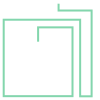

In [160]:
cpw.qgeometry_table('path')['geometry'].values[0]

In [21]:
path = cpw.qgeometry_table('path')['geometry'][4]

In [23]:
cpw.options.trace_width

'12.4 um'

In [24]:
coordinates = path.coords[:]

In [25]:
coordinates

[(0.0, -0.353),
 (0.0, -0.248),
 (0.252, -0.248),
 (0.252, -0.752),
 (-0.252, -0.752),
 (-0.252, -0.192),
 (0.308, -0.192),
 (0.308, -0.753),
 (0.392, -0.753),
 (0.392, -0.1247),
 (0.15, -0.1247),
 (0.15, -0.0747)]

In [26]:
design.parse_value(cpw.options.fillet)

0.03

In [114]:
1<2<3

True

In [117]:
corrected = []
r = design.parse_value(cpw.options.fillet)
center_pin = design.parse_value(cpw.options.trace_width)
gap_w = design.parse_value(cpw.options.trace_gap)

xover_len = center_pin + 2*gap_w
box_side = 0
xover_width = 0
if 0.05<=xover_len<=0.016:
    box_side = 0.008
    xover_width = 0.005
elif 0.016<xover_len<=0.027:
    box_side = 0.01
    xover_width = 0.0075
elif 0.027<xover_len<=0.032:
    box_side = 0.014
    xover_width = 0.01
else:
    print('error!!!')
out_box_len = box_side + 0.003*2

ab_box_len = 0.01
ab_inside_extend = r - np.sqrt(r**2 - ab_box_len**2)

r_in = r-center_pin/2-gap_w
# for i in coordinates:

In [119]:
from qiskit_metal import draw

In [164]:
square_in = draw.rectangle(box_side, box_side)
square_out = draw.rectangle(out_box_len, out_box_len)
squares = [square_in, square_out]
sq_in_left, sq_out_left = draw.translate(squares,-xover_len/2-out_box_len/2,0)
sq_in_right, sq_out_right = draw.translate(squares,xover_len/2+out_box_len/2,0)
arc_bridge = True
if arc_bridge == True:
    xover_rec = draw.rectangle(xover_len+ ab_inside_extend, xover_width )
    sq_in_right, sq_out_right = draw.translate([sq_in_right, sq_out_right],
                                               ab_inside_extend/2,0)
    base = draw.shapely.unary_union((sq_out_left, xover_rec, sq_out_right))
else:
    xover_rec = draw.rectangle(xover_len, xover_width)
    base = draw.shapely.unary_union((sq_out_left, xover_rec, sq_out_right))

top = [sq_in_left, sq_in_right]
angle_in_data = 315
rotation_angle = -(90-angle_in_data)
base = draw.rotate(base, rotation_angle)
top = draw.rotate(top, rotation_angle)

pos = (0,0)
x, y = pos
base = draw.translate(base, x, y)
top = draw.translate(top, x, y)


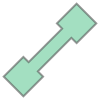

In [165]:
base

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

01:00PM 07s WARNING [_import_junction_gds_file]: Not able to find file:"Customized_Component/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/Users/wendy/Desktop/Wendy-qiskit-code/Customized_Component".


1

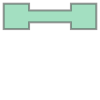

In [127]:
base

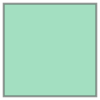

In [124]:
square_out

In [118]:
out_box_len

0.016

In [ ]:
def equals(a,b):
    return abs(a-b)<1e-6
def find_line_direction(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    if x1 == x2:
        if y1>y2:
            return 270
        elif y1<y2:
            return 90
        else:
            return 0
    elif equals(y1, y2):
        if x1>x2:
            return 180
        elif x1<x2:
            return 0
        else: return 0
    else:
        return ((np.arctan((y2-y1)/(x2-x1))*180/np.pi)+360)%360
def find_segment_length(p1,p2, type):
    x1,y1 = p1
    x2,y2 = p2
    d1 = np.absolute(x2-x1)
    d2 = np.absolute(y2-y1)
    if type == 'straight':
        return np.sqrt(d1**2+d2**2)
    elif equals(d1, d2) and (type == 'arc'):
        # print('arc!')
        return d1*np.pi/2
    else:
        r = max(d1, d2)
        r_min = min(d1, d2)
        theta = np.arctan(r_min/r)
        return d1*theta/2
segment_start = []
segment_end = []
segment_type = []
segment_angle = []
segment_length = []
seg_all = []

for i, cords in enumerate(coordinates):
    
    if i ==0:
        seg_all.append(coordinates[i])
        segment_start.append(coordinates[i])
        continue
    elif i == len(coordinates)-1:
        # seg_all.append(coordinates[i-1])
        seg_all.append(coordinates[i])
        segment_start.append(segment_end[-1])
        segment_end.append(coordinates[i])
        segment_type.append('straight')
        angle = find_line_direction(coordinates[i-1],coordinates[i])
        length = find_segment_length(coordinates[i-1],coordinates[i], type = 'straight')
        segment_length.append(length)
        segment_angle.append(angle)
        break
    angle = find_line_direction(coordinates[i-1],cords)
    next_angle = find_line_direction(cords,coordinates[i+1])
    # print(angle, next_angle)
    # print(np.absolute(angle-next_angle))
    if angle == next_angle:
        continue
    elif np.absolute(angle-next_angle)%90==0:
        x, y = cords
        x0,y0 = coordinates[i-1]
        x_modi = x - np.sign(x - x0)*r
        y_modi = y - np.sign(y - y0)*r
        if i == 1:
            pass
        else:
            segment_start.append(segment_end[-1])
        segment_end.append((x_modi,y_modi))
        segment_type.append('straight')
        segment_angle.append(angle)
        length = find_segment_length(segment_start[-1],segment_end[-1], type = 'straight')
        segment_length.append(length)


        x1,y1 = coordinates[i+1]
        x1_modi = x + np.sign(x1 - x)*r
        y1_modi = y + np.sign(y1 - y)*r
        segment_start.append((x_modi,y_modi))
        segment_end.append((x1_modi,y1_modi))
        segment_type.append('arc')
        angle = (angle+next_angle)/2
        segment_angle.append(angle)
        length = find_segment_length(segment_start[-1],segment_end[-1], type = 'arc')
        segment_length.append(length)

        # seg_all.append(coordinates[i-1])
        seg_all.append((x_modi,y_modi))
        seg_all.append((x1_modi,y1_modi))
        
        # segment_type.append('straignt')
        # segment_angle.append((next_angle))
        
    

In [107]:


def find_next_ab(segment_all, distance, ab_all, clockwise = 1):
    last_pt = ab_all['coord'][-1]
    last_len = ab_all['length_remain'][-1]
    seg_num = ab_all['seg_num'][-1]
    smaller = True
    last_angle = segment_all['angle'][seg_num]
    if last_len >= distance:
        ab_all['length_remain'].append(last_len-distance)
        ab_all['seg_num'].append(seg_num)
        x,y = last_pt
        if segment_all['type'][seg_num] == 'straight':
            angle = last_angle/180*np.pi
            x_new = x + distance*np.cos(angle)
            y_new = y + distance*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            angle = angle*180/np.pi
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(False)
            
            return ab_all, True
        else:
            len_needed = distance
            r = cpw_turn_radi
            angle = len_needed/r
            x_new = x + r*np.cos(angle)
            y_new = y + r*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            if len(ab_all['angle']) == 0:
                angle = (angle*180/np.pi+last_angle+360)%360
            elif ab_all['seg_num'][-1]==seg_num:
                angle = ab_all['angle'][-1]
            else:
                angle = (angle*180/np.pi+segment_all['angle'][seg_num-1]+360)%360
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(True)
            return ab_all, True
    elif seg_num == len(segment_all['type'])-1:
        return ab_all, False
        
    else:
        smaller = True
        len_needed = distance-last_len
        while smaller:
            seg_num += 1
            next_len = segment_all['length'][seg_num]
            if next_len >= len_needed:
                break
            elif (next_len < len_needed) and (seg_num == len(segment_all['type'])-1):
                return ab_all, False
            else:
                len_needed -= next_len
        ab_all['seg_num'].append(seg_num)
        ab_all['length_remain'].append(next_len-len_needed)
        x0, y0 = segment_all['start'][seg_num]
        last_angle = segment_all['angle'][seg_num]
        if segment_all['type'][seg_num] == 'straight':
            angle = last_angle/180*np.pi
            x_new = x0 + len_needed*np.cos(angle)
            y_new = y0 + len_needed*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            angle = angle*180/np.pi
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(False)
            
            return ab_all, True
        else:
            
            r = cpw_turn_radi
            angle = len_needed/r #+ segment_all['angle'][seg_num-1]/180*np.pi
            # print(x0,y0,angle*180/np.pi)
            x_new = x0 + r*np.cos(angle)
            y_new = y0 + r*np.sin(angle)
            ab_all['coord'].append((x_new,y_new))
            # print(angle*180/np.pi)
            angle = -clockwise*angle*180/np.pi+ segment_all['angle'][seg_num-1]
            angle%=360
            # print(angle)
            ab_all['angle'].append(angle)
            ab_all['inside_extend'].append(True)
            return ab_all, True

In [69]:
np.cos(0.8)

0.6967067093471654

In [100]:
# ab = {}
# ab['coord'] = [(-0.12562833058845949, -0.752)]
# ab['inside_extend'] = [0]
# ab['angle'] = [180.000000]
# ab['seg_num'] = [6]
# ab['length_remain'] = [0.096372]

In [111]:
ab = {}
ab['coord'] = [(0,-0.353)]
ab['inside_extend'] = [False]
ab['angle'] = [90]
ab['seg_num'] = [0]
ab['length_remain'] = [0.075]

In [98]:
find_next_ab(segment, 0.1, ab)

6.928969602448769
173.07103039755123


({'coord': [(-0.12562833058845949, -0.752),
   (-0.19221910583840002, -0.7483808367078039)],
  'inside_extend': [0, 0.0017157287525380975],
  'angle': [180.0, 173.07103039755123],
  'seg_num': [6, 7],
  'length_remain': [0.096372, 0.04349588980384689]},
 True)

In [85]:
segment = {}
segment['start'] = segment_start
segment['end'] = segment_end
segment['angle'] = segment_angle
segment['length'] = segment_length
segment['type'] = segment_type

In [86]:
pd.DataFrame(segment)

,start,end,angle,length,type
0,"(0.0, -0.353)","(0.0, -0.278)",90.0,0.075000,straight
1,"(0.0, -0.278)","(0.03, -0.248)",45.0,0.047124,arc
2,"(0.03, -0.248)","(0.222, -0.248)",0.0,0.192000,straight
3,"(0.222, -0.248)","(0.252, -0.278)",135.0,0.047124,arc
4,"(0.252, -0.278)","(0.252, -0.722)",270.0,0.444000,straight
5,"(0.252, -0.722)","(0.222, -0.752)",225.0,0.047124,arc
6,"(0.222, -0.752)","(-0.222, -0.752)",180.0,0.444000,straight
7,"(-0.222, -0.752)","(-0.252, -0.722)",135.0,0.047124,arc
8,"(-0.252, -0.722)","(-0.252, -0.222)",90.0,0.500000,straight
9,"(-0.252, -0.222)","(-0.222, -0.192)",45.0,0.047124,arc


In [112]:
test = True
while test:

    ab, test = find_next_ab(segment, 0.1, ab)

In [83]:
find_line_direction((0.252, -0.722),(0.222, -0.752))

45.0

In [113]:
pd.DataFrame(ab)

,coord,inside_extend,angle,seg_num,length_remain
0,"(0, -0.353)",False,90.000000,0,0.075000
1,"(0.020172367322491693, -0.2557946944041189)",True,42.253517,1,0.022124
2,"(0.10787611019615312, -0.248)",False,0.000000,2,0.114124
3,"(0.20787611019615312, -0.248)",False,0.000000,2,0.014124
4,"(0.252, -0.31675222039230627)",False,270.000000,4,0.405248
5,"(0.252, -0.4167522203923063)",False,270.000000,4,0.305248
6,"(0.252, -0.5167522203923063)",False,270.000000,4,0.205248
7,"(0.252, -0.6167522203923063)",False,270.000000,4,0.105248
8,"(0.252, -0.7167522203923062)",False,270.000000,4,0.005248
9,"(0.17437166941154053, -0.752)",False,180.000000,6,0.396372


In [179]:
pd.DataFrame(segment)

,start,end,angle,length,type
0,"(0.0, -0.353)","(0.0, -0.278)",90.0,0.075000,straight
1,"(0.0, -0.278)","(0.03, -0.248)",45.0,0.047124,arc
2,"(0.03, -0.248)","(0.222, -0.248)",0.0,0.192000,straight
3,"(0.222, -0.248)","(0.252, -0.278)",315.0,0.047124,arc
4,"(0.252, -0.278)","(0.252, -0.722)",270.0,0.444000,straight
5,"(0.252, -0.722)","(0.222, -0.752)",45.0,0.047124,arc
6,"(0.222, -0.752)","(-0.222, -0.752)",180.0,0.444000,straight
7,"(-0.222, -0.752)","(-0.252, -0.722)",315.0,0.047124,arc
8,"(-0.252, -0.722)","(-0.252, -0.222)",90.0,0.500000,straight
9,"(-0.252, -0.222)","(-0.222, -0.192)",45.0,0.047124,arc


In [132]:
ab_coord = []
ab_angle = []
ab_inside = []
ab_seg_remaining = []
ab_seg_num = []



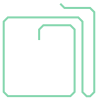

In [102]:
LineString(segment_start)

In [68]:
segment_end

[(0.0, -0.278),
 (-0.03, -0.248),
 (0.252, -0.722),
 (0.28200000000000003, -0.752),
 (-0.222, -0.752),
 (-0.252, -0.782),
 (-0.252, -0.222),
 (-0.28200000000000003, -0.192),
 (0.362, -0.753),
 (0.392, -0.783),
 (0.392, -0.1547),
 (0.42200000000000004, -0.1247),
 (0.18, -0.1247),
 (0.15, -0.1547),
 (0.15, -0.0747)]

In [48]:
'mix' in str(type(cpw))

True

In [18]:
q1.options.layer = qubit_layer
cpw.options.layer = qubit_layer
TQ1.options.layer = qubit_layer
j.options.layer = junction_layer
gui.rebuild()
gui.autoscale()

In [22]:
design.chips.main.size['size_x'] = '10mm'
design.chips.main.size['size_y'] = '10mm'
gui.rebuild()
a_gds = design.renderers.gds

In [39]:
a_gds.options.cheese.edge_nocheese = '300um'
a_gds.options.no_cheese.buffer = '50um'

In [27]:
a_gds.options['cheese']['view_in_file']['main'][qubit_layer] = True
a_gds.options['no_cheese']['view_in_file']['main'][qubit_layer] = True
a_gds.options['cheese']['view_in_file']['main'][junction_layer] = False
a_gds.options['no_cheese']['view_in_file']['main'][junction_layer] = True

In [40]:
a_gds.export_to_gds('export_test.gds')

08:15PM 18s WARNING [_qgeometry_to_gds]: Unexpected shapely object geometry.The variable qgeometry_element is <class 'numpy.float64'>, method can currently handle Polygon and FlexPath.
08:15PM 18s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/Users/wendy/Desktop/resources".


1

In [30]:
a_gds = design.renderers.gds

In [157]:
a_gds.options.tolerance = '0.00001'
a_gds.options.cheese.edge_nocheese = '300um'
a_gds.options.no_cheese.buffer = '40um'

In [224]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': True,
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': 'Customized_Component/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: False}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '0um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: False}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2',
 'ground_main_1': {'view_in_file': {'main': {1: True}}}}

In [208]:
a_gds.options['path_filename'] = 'Customized_Component/Fake_Junctions.GDS'

In [51]:
a_gds.options.no_cheese.buffer = '0um'

a_gds.options['cheese']['view_in_file']['main'][5] = False
a_gds.options['no_cheese']['view_in_file']['main'][5] = False
a_gds.options['ground_plane'] = True

In [49]:
q1.options.layer = 1
d.options.layer = 5
gui.rebuild()

0.002
10.0 nH 0.1 uA / um2 0.00024198969005548028


In [25]:
a_gds.options['ground_plane'] = True

In [52]:

# a_gds.options['short_segments_to_not_fillet'] = True
# a_gds.options['check_short_segments_by_scaling_fillet'] = 1.0
a_gds.export_to_gds('Dolan.gds')#, highlight_qcomponents=['TQ1'])

03:53PM 34s WARNING [_qgeometry_to_gds]: Unexpected shapely object geometry.The variable qgeometry_element is <class 'numpy.float64'>, method can currently handle Polygon and FlexPath.
03:53PM 34s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/Users/wendy/Desktop/resources".


1

In [32]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': True,
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [127]:
design.components.keys()

['d']